In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
#import data
df = pd.read_csv(r'C:\Users\mansg\Documents\Big Data\Big_Data_EXAM2025\Data\Cancer2025exam.csv')

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mansg\\Documents\\Big Data\\Big_Data_EXAM2025\\Data\\Cancer2025exam.csv'

In [12]:

#load data
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape)


(1715, 201)


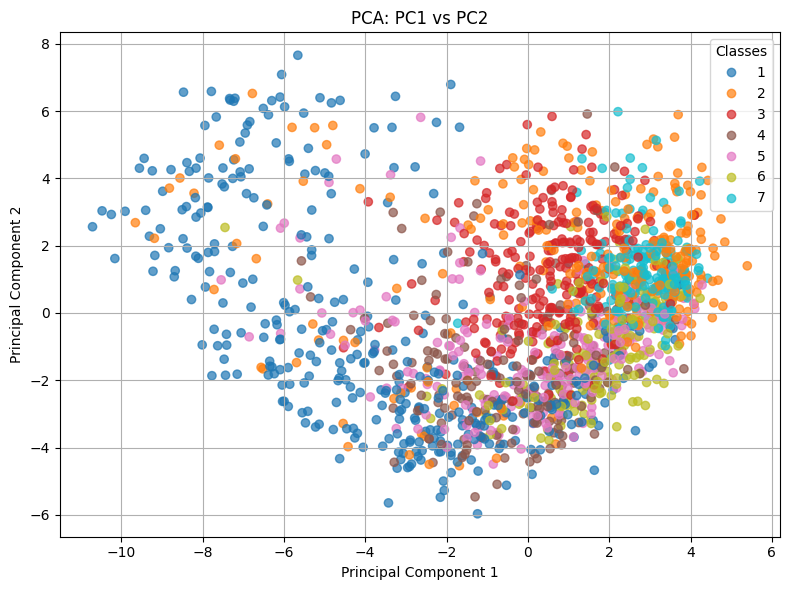

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Extract PC1 and PC2
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show()


In [26]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1715, 201)
y shape: (1715,)


In [27]:
models = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 40, 2)],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    "LDA": (LinearDiscriminantAnalysis(), {
    }),
    
    "LogReg": (LogisticRegression(max_iter=1000), {
        'clf__C': [0.01, 0.1, 1, 10],
    }),
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [10, 20, 30],
    }),
    
    "SVM": (SVC(), {
        'clf__C': [0.1, 1, 10],
    }),
    
    "MLP": (MLPClassifier(max_iter=1000), {
        'clf__hidden_layer_sizes': [(50,), (100,),(150,)],
        'clf__alpha': [0.0001, 0.001, 0.01],
    })
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#how many train/test splits to run
repeats = 2

#declare variables to store important information: test acc, best params and confusion matrix values
test_accuracies = {name: [] for name in models.keys()}
best_params_across_runs = {name: [] for name in models.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models.keys()}
run_metrics = {name: [] for name in models.keys()}

#Outer loop for test/train splits
for i in range(repeats):
    print(f"\nRepetition {i+1}/{repeats}")
    
    #split data with stratified sampling into 20% test and 80% train
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)
    
    #Inner loop with 10-fold CV
    for name, (clf, param_grid) in models.items():

        #pipeline of all classifiers and also normalizing data
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
        
        #grid parameter search with 10-fold CV and train accuracy to choose best parameters
        grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)
        
        #Compute and save important metrics, test accuracy and best parameters
        acc = accuracy_score(y_test, grid.predict(X_test))
        test_accuracies[name].append(acc)
        best_params_across_runs[name].append(grid.best_params_)

        train_acc = accuracy_score(y_train, grid.predict(X_train))
        best_cv_score = grid.best_score_
        
        #compute values for confusion matrix and save in sum for all train/test split runs
        y_pred = grid.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix_sums[name] += cm

        run_metrics[name].append({
            'train_acc': train_acc,
            'test_acc': acc,
            'cv_acc': best_cv_score,
            'best_params': grid.best_params_
        })

        sensitivities = []
        specificities = []        
        #compute sensitivity and specificity
        for i in range(len(cm)):
            TP = cm[i, i]
            FN = cm[i, :].sum() - TP
            FP = cm[:, i].sum() - TP
            TN = cm.sum() - (TP + FN + FP)
            
            sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
            specificity = TN / (TN + FP) if TN + FP > 0 else 0
            
            sensitivities.append(sensitivity)
            specificities.append(specificity)

        #averages for sensitivity and specificity
        avg_sensitivity = np.mean(sensitivities)
        avg_specificity = np.mean(specificities)  

        print(f"{name}: {acc:.4f}")
    


Repetition 1/5
KNN: 0.8047
LDA: 0.8309
LogReg: 0.8426
RandomForest: 0.8863
SVM: 0.8601
MLP: 0.8222

Repetition 2/5
KNN: 0.8163
LDA: 0.8076
LogReg: 0.8367
RandomForest: 0.8659
SVM: 0.8542
MLP: 0.7988

Repetition 3/5
KNN: 0.8163
LDA: 0.8251
LogReg: 0.8222
RandomForest: 0.8542
SVM: 0.8367
MLP: 0.7522

Repetition 4/5
KNN: 0.8134
LDA: 0.8367
LogReg: 0.8251
RandomForest: 0.8601
SVM: 0.8484
MLP: 0.8251

Repetition 5/5
KNN: 0.8426
LDA: 0.8280
LogReg: 0.8367
RandomForest: 0.8805
SVM: 0.8397
MLP: 0.8076



KNN Best Parameters Across Runs:
  Run 1: {'clf__metric': 'manhattan', 'clf__n_neighbors': 17, 'clf__weights': 'distance'}
  Run 2: {'clf__metric': 'manhattan', 'clf__n_neighbors': 13, 'clf__weights': 'distance'}
  Run 3: {'clf__metric': 'manhattan', 'clf__n_neighbors': 19, 'clf__weights': 'distance'}
  Run 4: {'clf__metric': 'manhattan', 'clf__n_neighbors': 29, 'clf__weights': 'distance'}
  Run 5: {'clf__metric': 'manhattan', 'clf__n_neighbors': 31, 'clf__weights': 'distance'}

LDA Best Parameters Across Runs:
  Run 1: {}
  Run 2: {}
  Run 3: {}
  Run 4: {}
  Run 5: {}

LogReg Best Parameters Across Runs:
  Run 1: {'clf__C': 0.01}
  Run 2: {'clf__C': 0.01}
  Run 3: {'clf__C': 0.01}
  Run 4: {'clf__C': 0.01}
  Run 5: {'clf__C': 0.01}

RandomForest Best Parameters Across Runs:
  Run 1: {'clf__max_depth': 30, 'clf__n_estimators': 300}
  Run 2: {'clf__max_depth': 20, 'clf__n_estimators': 200}
  Run 3: {'clf__max_depth': 30, 'clf__n_estimators': 300}
  Run 4: {'clf__max_depth': 10, 'clf__

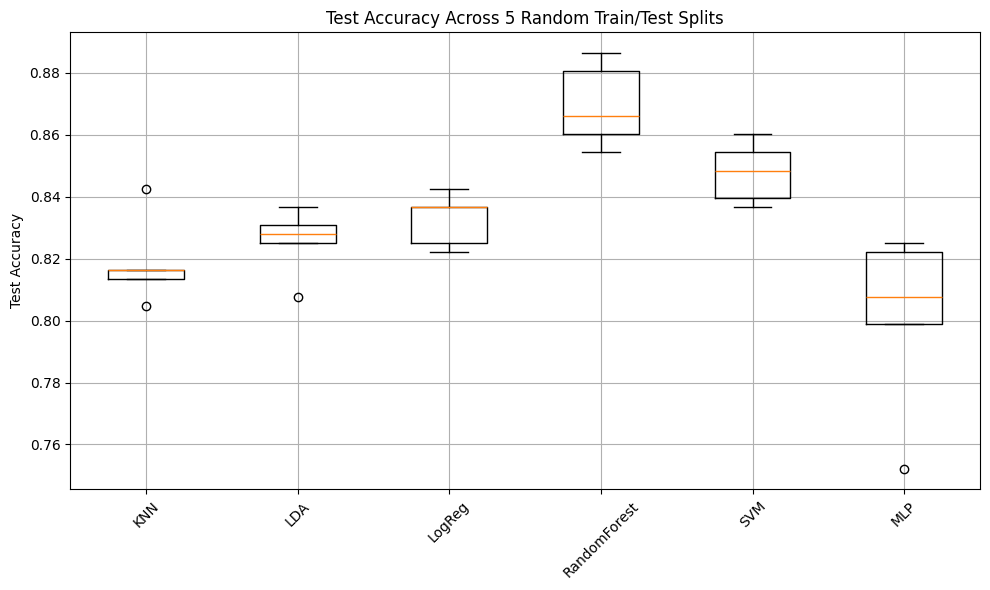

In [21]:
# Print best params for each model across all runs
for name, params_list in best_params_across_runs.items():
    print(f"\n{name} Best Parameters Across Runs:")
    for i, params in enumerate(params_list):
        print(f"  Run {i+1}: {params}")
        
plt.figure(figsize=(10, 6))
plt.boxplot([test_accuracies[name] for name in models.keys()], labels=models.keys())

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across 5 Random Train/Test Splits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

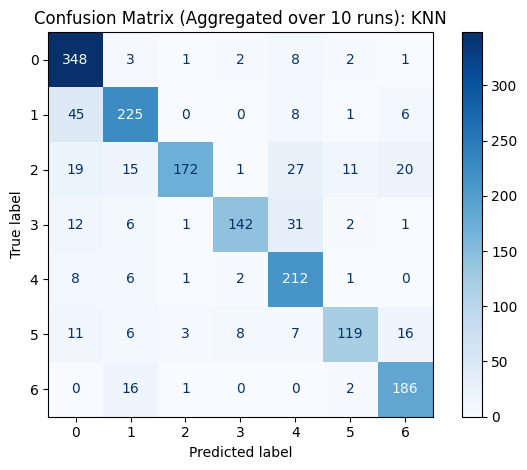

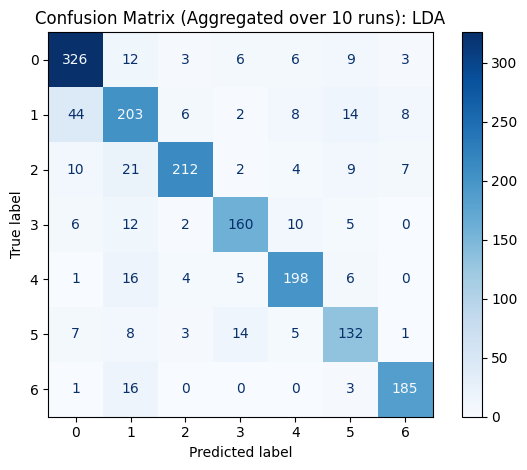

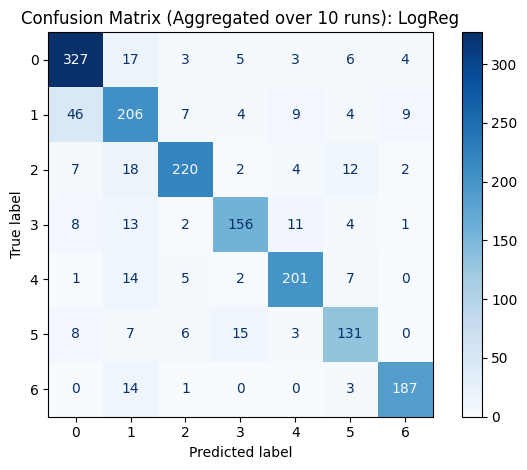

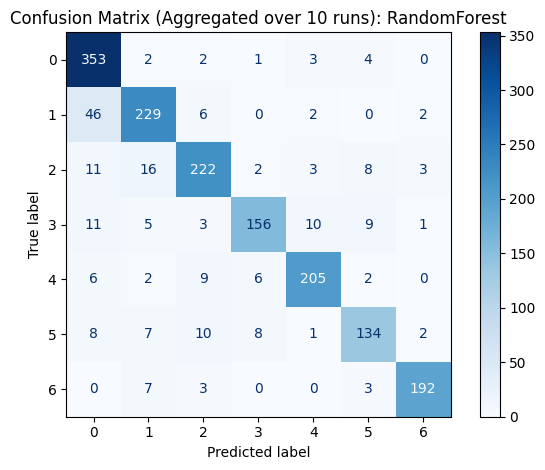

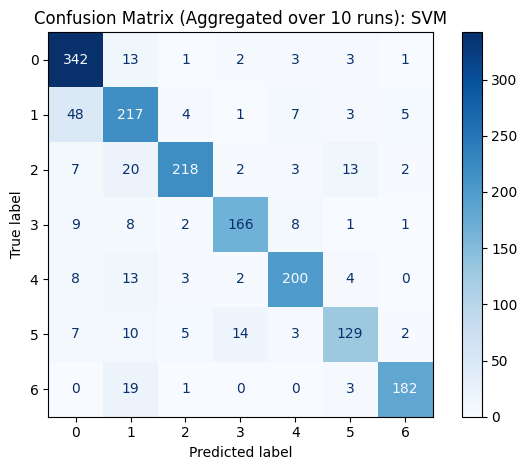

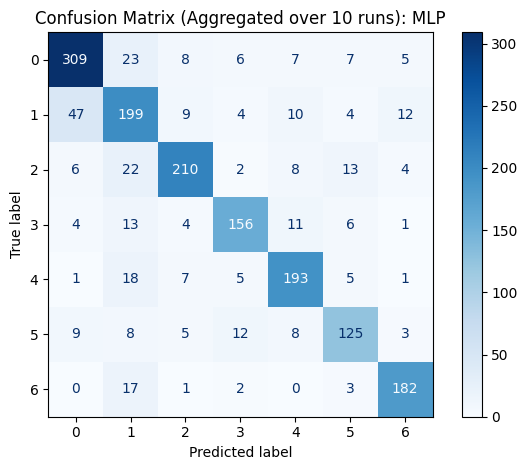

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for name, cm_sum in conf_matrix_sums.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Aggregated over 10 runs): {name}')
    plt.tight_layout()
    plt.show()